<a href="https://colab.research.google.com/github/51rL1N5/Prova_Esig/blob/master/taxi_fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install kaggle

# !mkdir .kaggle

# import json

# token = {"username":"felipeols","key":"31e9d128303c584a875b2ffd1f394c91"}

# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)
    
    
# !cp .kaggle ~/

# !kaggle competitions download -c new-york-city-taxi-fare-prediction

# !unzip \*.zip

In [267]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

import dask.dataframe as dd
import os
from tqdm import tqdm


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go


import folium
import folium.plugins

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()


Loading BokehJS ...

# Carregamento dos dados


---

  O csv que contém os dados é extremamente grande, então precisaremos de uma abordagem mais inteligente e menos "naive" para poder trabalhar com a maior quantidade de dados possível


In [0]:

# sample = pd.read_csv('train.csv', nrows=5)

# sample.head()

In [0]:
# sample.dtypes

Usar um float64 (16 casas decimais) para lear coordenadas/taxa é um excesso de precisão desnecessário que está ocupando muita memória. 

Float32 (7 casas decimais) é suficiente para isso

Bem como no caso do numero de passageiros, int64 é exagero. É suficiente ustilizar uint8, que nos permitirá representar até o numero 2^8 -- que, para o problema, nunca será atingido pela natureza do taxi 

In [0]:
# # Então, vamos forçar que as colunas a terem esses tipos

# datatypes = {
#               'fare_amount': 'float32',
#               'pickup_longitude': 'float32',
#               'pickup_latitude': 'float32',
#               'dropoff_longitude': 'float32',
#               'dropoff_latitude': 'float32',
#               'passenger_count': 'uint8'
#             }

# cols = list(datatypes.keys())

# cols.append('pickup_datetime')

# chunksize = 10 ** 6

# chunk = pd.read_csv('train.csv', usecols=cols, dtype=datatypes, nrows=chunksize)


# df_list = []

# for df_chunk in pd.read_csv('train.csv', usecols=cols, dtype=datatypes, chunksize=chunksize):
  
#   df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
#   df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
#   df_list.append(df_chunk) 



In [0]:
# df_todo = pd.concat(df_list)

# del df_list

# df_todo.info()

In [0]:
# os.makedirs('tmp', exist_ok=True)
# df_todo.to_feather('tmp/taxi-train-no-gps.feather')


In [0]:
# import feather

# chunk = feather.read_dataframe('tmp/taxi-train-no-gps.feather')

In [0]:
# Como o banco de dados é muito grnade, irei analizar-lo por blocos
# Que são suficientemente grandes para podermos supor que representam bem uma aproximação
# da estatística global.

# Logo após processar todos eles, é necessário fazer uma média das análises (estacionaridade)



chunksize = 10 ** 6

chunk = pd.read_csv('train.csv', nrows=chunksize)

In [273]:
# Olhando a cara dos dados

chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
key                  1000000 non-null object
fare_amount          1000000 non-null float64
pickup_datetime      1000000 non-null object
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      1000000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [0]:
# Primeiro, vamos limpar os dados 

"""
----- Limpeza de coordenadas -------------

Sei que a latitude é um número limitado entre -90 <= lat <= 90  
Bem como a longitude é limitada entre -180 <= long <= 180

Então, irei eliminar dados que apresentarem esses dados expúrios

"""

chunk = chunk[
               ( abs(chunk['pickup_latitude']) <= 90 ) & ( abs(chunk['pickup_longitude']) <= 180 ) & ( abs(chunk['dropoff_latitude']) <= 90 ) & ( abs(chunk['dropoff_longitude']) <= 180 )
             ]

"""
----- Limpeza de taxas -------------------

Não faz sentido que tenhamos preço pago negativo
Logo, eliminaremos os dados que possuam tal característica

Também, a taxa inicial (base) de uma viagem de taxi é 2.50 então vamos eliminar todos os dados que estão abaixo de 2.50

"""

chunk = chunk[
               (chunk['fare_amount'] >= 2.50)
             ]

"""
----- Limpeza do número de passageiros ------

De acordo com https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxi

No máximo 4 ou 5, acrescido de uma criança abaixo de 7 anos (que ficará no colo de um adulto) poderão ir no taxi

Logo, no máximo teremos 6 passageiros
"""

chunk = chunk[
               (chunk['passenger_count'] <=6)
             ]

"""
----- Remover, caso existam, dados nulos (faltantes) -------------
"""
chunk = chunk.drop(chunk[chunk.isnull().any(1)].index, axis=0)

Como temos dados que dependem de localizações, precisamos garantir que eles se encontram em localizações válidas. 

A partir desse site (https://www.travelmath.com/cities/New+York,+NY) vemos que as coordenadas da cidade de NY:

Latitude    =  40.7141667

Longitude = -74.0063889

Então, vamos ver como estão dispostos os pontos para saber se existe alguma irregularidade 

In [0]:
# Carregar o mapa

nyc_mapa = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')


# definir limites do mapa
# BB é Boundary Box
# E as componentes dele serão
# [ Limite inferior da longitude, limite superior da longitude, limite inferior da latitude, limite superior da latitude]

BB = (-74.5, -72.8, 40.5, 41.8)

BB_zoom = (-74.3, -73.7, 40.5, 40.9)


nyc_mapa_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [0]:
def filtrar_pela_BB (df, BB):
  return df[(df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
           ]

In [0]:
# Função para podermos plotar os dados no mapa

def plot_on_map(df, BB, mapa, s=10, alpha=0.2):
  fig, axs = plt.subplots(1, 2, figsize=(20,10))
  axs[0].scatter(df['pickup_longitude'], df['pickup_latitude'], zorder=1, alpha=alpha, c='r', s=s)
  axs[0].set_xlim((BB[0], BB[1]))
  axs[0].set_ylim((BB[2], BB[3]))
  axs[0].set_title('Pickup locations')
  axs[0].imshow(mapa, zorder=0, extent=BB)

  axs[1].scatter(df['dropoff_longitude'], df['dropoff_latitude'], zorder=1, alpha=alpha, c='r', s=s)
  axs[1].set_xlim((BB[0], BB[1]))
  axs[1].set_ylim((BB[2], BB[3]))
  axs[1].set_title('Dropoff locations')
  axs[1].imshow(mapa, zorder=0, extent=BB)
  

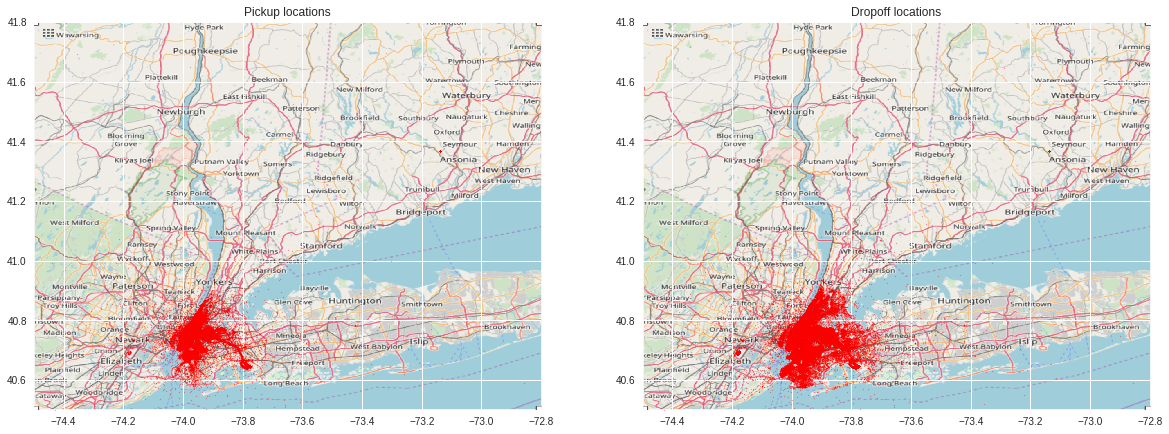

In [278]:
dados_BB = filtrar_pela_BB(chunk, BB)

plot_on_map(dados_BB, BB, nyc_mapa, s=1, alpha=0.3)

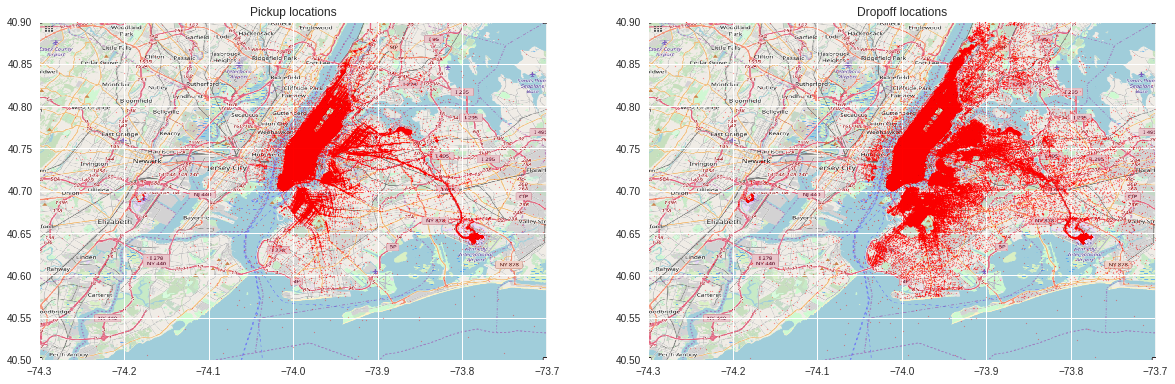

In [279]:
dados_BB_zoom = filtrar_pela_BB(chunk, BB_zoom)

plot_on_map(dados_BB_zoom, BB_zoom, nyc_mapa_zoom, s=1, alpha=0.3)

 **Como visto no gráfico acima, temos pontos em cima da água que são anomalias. Logo, devemos os remover**

Então, para remover os pontos acima da água podemos fazer o seguinte:

Vamos criar um mapa booleano terra/água




In [0]:
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

#plt.figure(figsize=(8,8))
#plt.imshow(nyc_mapa, zorder=0)
#plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.


def remove_datapoints_from_water(df, BB):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    #BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y   = lonlat_to_xy(df['pickup_longitude'], df['pickup_latitude'], 
                                        nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df['dropoff_longitude'], df['dropoff_latitude'], 
                                        nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index    
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]

    
    # return only datapoints on land
    return df[idx]
 



 
dados_BB = remove_datapoints_from_water(dados_BB, BB)

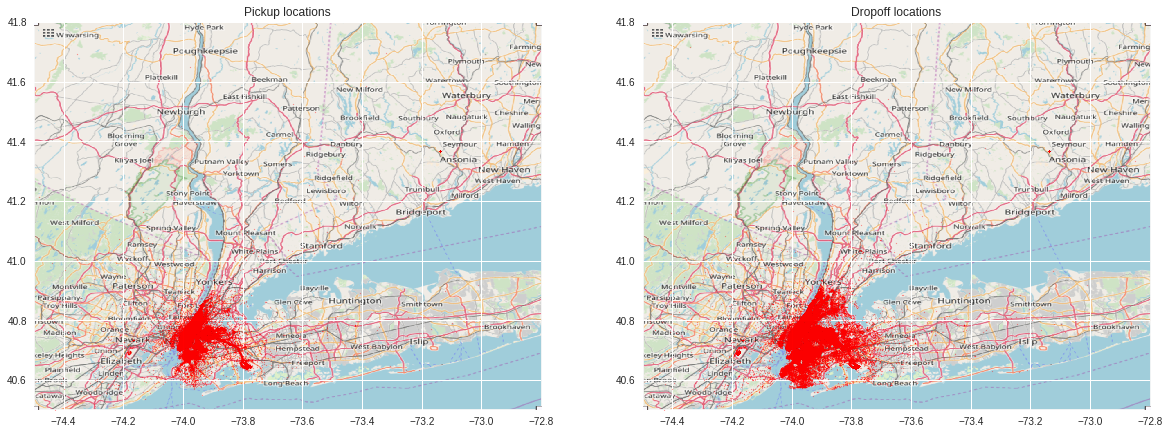

In [281]:
plot_on_map(dados_BB, BB, nyc_mapa, s=1, alpha=0.3)

In [0]:
chunk = dados_BB

In [283]:
# Agora, criaremos um indicador de distancia percorrida, bem como criarei mais colunas
# Com mais informação util, como Dia, Mês, Ano, hora, minuto, segundo


# Para calcularmos a distancia, se faz necessário usar a formula de haversine que pega dois pontos em uma esfera (latitude e longitude) e converte para distancia em metros

def haversine_1 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(chunk[lat1])
  phi_2 = np.radians(chunk[lat2])

  delta_phi    = np.radians(chunk[lat2] - chunk[lat1])
  delta_lambda = np.radians(chunk[long2] - chunk[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  chunk['distancia'] = d 
  return d
                                 

haversine_1('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0          1.030764
1          8.450134
2          1.389525
3          2.799270
4          1.999157
5          3.787239
6          1.555807
7          4.155444
8          1.253232
9          2.849627
10         1.374577
12         0.717767
13         2.019384
14         1.671445
16         2.609774
17         1.511904
18         0.921952
19         0.399179
20         1.686861
21         2.292470
22         0.924296
23         1.403958
24         1.017773
25         2.531947
27         0.328771
28         4.073463
29         0.808153
30         0.871913
31         6.703551
32         9.403296
            ...    
999970     1.800660
999971    16.888650
999972     0.443274
999973     0.509990
999974     6.774274
999975     9.357706
999976     4.093045
999977     5.314221
999978     1.842736
999979     3.689741
999980     4.456025
999981     3.622864
999982     1.162477
999983     0.806466
999984     8.401025
999985     1.344648
999986     0.821492
999987     0.240398
999988     0.000000


In [0]:
# Removendo os NaNs

chunk = chunk.dropna(how = 'any', axis = 'rows')

In [0]:
# Distancia de Manhattan

# Vou usar essa métrica também pois ela representa melhor a distancia percorrida de fato pelo taxista

from math import atan2

def distance(coord1lat, coord1lon, coord2lat, coord2lon):
    R = 6373.0
    lat1 = np.radians(float(coord1lat))
    lon1 = np.radians(float(coord1lon))
    lat2 = np.radians(float(coord2lat))
    lon2 = np.radians(float(coord2lon))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * atan2(np.sqrt(a), np.sqrt(1 - a))
  
    distance = R * c

    return distance

def manhattan(coord1lat, coord1lon, coord2lat, coord2lon):
    d1=distance(coord1lat, coord2lon, coord2lat, coord2lon)
    d2=distance(coord1lat, coord1lon, coord1lat, coord2lon)
    
    return d1+d2
  
chunk['Manhattan dist']=chunk[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].apply(lambda x: manhattan(x[0], x[1], x[2], x[3]), axis=1)

In [0]:
# converter string para date_time, para obtermos os dados temporais

chunk['key']             = pd.to_datetime(chunk['key'])

chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'])

In [287]:
# Olhando a cara dos atributos dos dados após a conversão

chunk.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distancia                   float64
Manhattan dist              float64
dtype: object

In [0]:
# Separando os dados temporais para podermos visualizar-los melhor

chunk['Ano'] = chunk['pickup_datetime'].dt.year
chunk['Mes'] = chunk['pickup_datetime'].dt.month
chunk['Dia'] = chunk['pickup_datetime'].dt.day
chunk['Dia da semana'] = chunk['pickup_datetime'].dt.dayofweek
chunk['Horario'] = chunk['pickup_datetime'].dt.hour

In [0]:
# Colocar variáveis de estado para
# se está de:
# noite
# madrugada

def noite(x):
  if ((x['Horario'] <=20) & (x['Horario'] >=17) ):
    return 1
  else:
    return 0

def madrugada(x):
  if ((x['Horario'] <= 5) | (x['Horario'] >=21) ):
    return 1
  else:
    return 0
  
chunk['Noite'] = chunk.apply(lambda x: noite(x), axis=1)
chunk['Madrugada'] = chunk.apply(lambda x: madrugada(x), axis=1)


Por fim, removerei as corridas em que não houve distância percorrida

In [0]:
chunk = chunk[chunk['distancia']      !=0]
chunk = chunk[chunk['Manhattan dist'] !=0]

# **Análise exploratória de dados**

---



**Como é cobrada a taxa de taxi em NYC:**

1 - A taxa inicial é de **$2.50**

2 - Mais  **50 cents ** a cada 1/5 de Milha (0,321869 km) acima de 12 mph (19,3121 km/h) ou a cada minuto em tráfico devagar

3 - **50 cents**  de taxa adicional para todas viagens que terminam em NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange ou Putnam Counties

4 - ** 30 cents** de taxa de melhoramento

5 - ** 50 cents ** de taxa para tráfego entre **8pm** e **6am**

6 - ** $1.00 ** de taxa de hora do rush (**4pm ate 8pm**) em dias de semana, não se aplicando a feriados

7 -  Taxa de congestionamento de ** 2.50 ** (Taxi amarelo) , ** 2.75** (Taxi verde ou FHV) ou **75 cents** para corridas compartilhadas para todas as corridas que começam, terminam ou passam por Manhattan south of 96th street

8 - Pedágios e gorjetas são acrescidos caso necessário

**Hipóteses:**

1 - O Número de pessoas impacta no valor da taxa

2 - O horário o qual o taxi foi pego impacta no valor

3 - O dia da semana o qual o taxi foi pego impacta no valor

4 - O local de origem do taxi tem relação com a taxa?

5 - A distância percorrida impacta no valor da taxa?

6 - O ano impacta na taxa?



#**Análise de correlação dos dados**

---



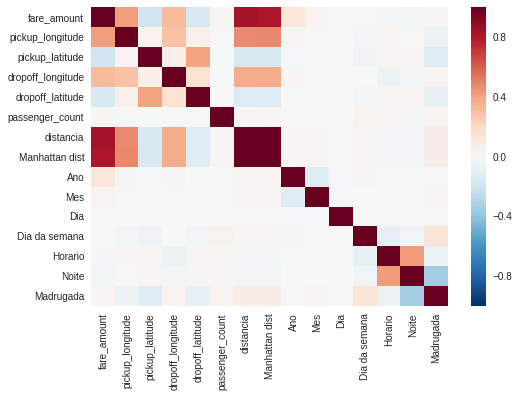

In [291]:
# Primeiro, vamos observar uma correlação dos dados para saber o que buscar de maneira mais eficiente

corr = chunk.corr()

sbs.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

Por esse gráfico, já dá para criar uma noção sobre os principais fatores influenciadores da taxa:

    - Coordenadas de pickup

    - Coordenadas de dropoff

    - Distancia (euclidiana)

    - Distancia (Manhattan)

    - Ano

##**Hipótese 1**

---
O número de pessoas impacta no valor da taxa?


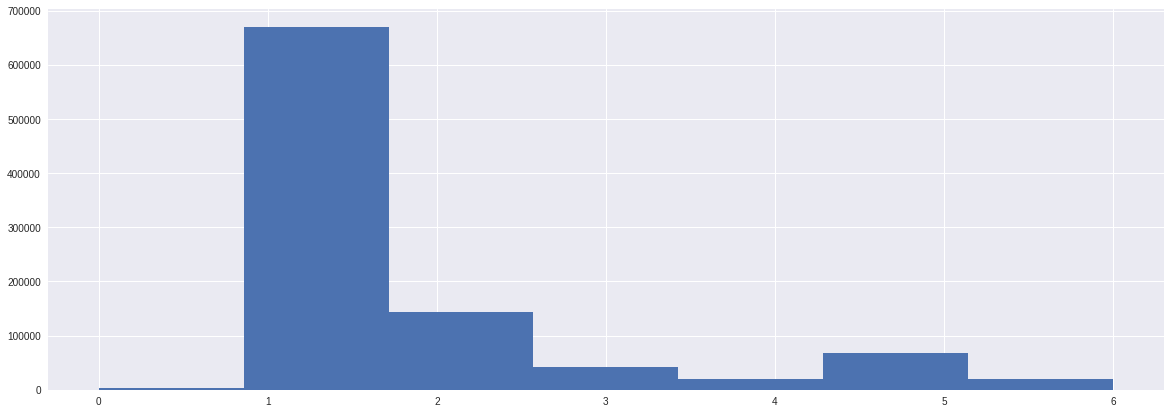

In [292]:
# Inicialmente, vamos ver a distribuição do número de pessoas

plt.figure(figsize=(20,7))

chunk['passenger_count'].hist(bins=7)

Text(0, 0.5, 'Taxa paga')

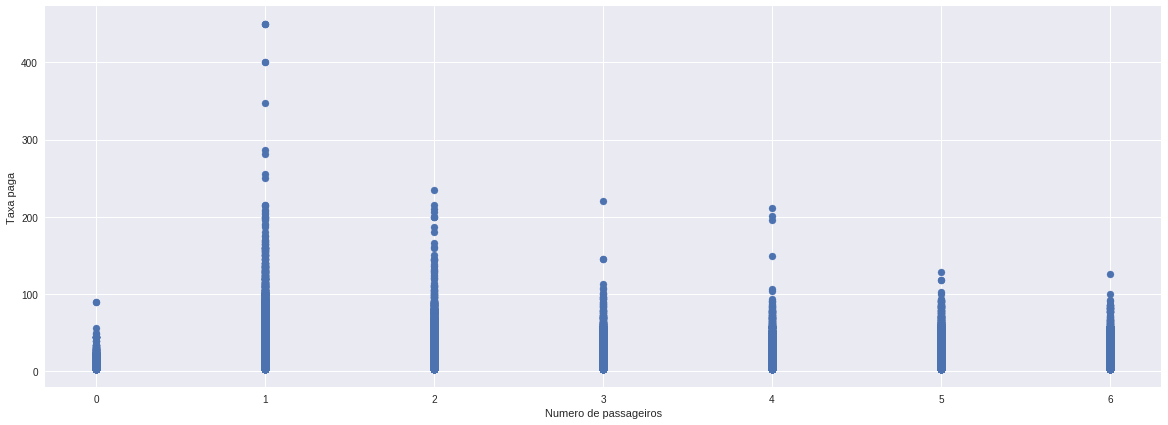

In [293]:
# Agora, é interessante ver como está a distribuição de número de passageiros x taxa paga

plt.figure(figsize=(20,7))

plt.scatter(x=chunk['passenger_count'], y=chunk['fare_amount'])
plt.xlabel('Numero de passageiros')
plt.ylabel('Taxa paga')

Dos dois gráficos, podemos inferir que a viagem de taxi para 1 passageiro é mais frequente. As taxas pagas mais altas também vem da viagem para 1 passageiro

#**Hipótese 2**

---

O horário impacta na taxa paga?

Text(0, 0.5, 'Frequencia')

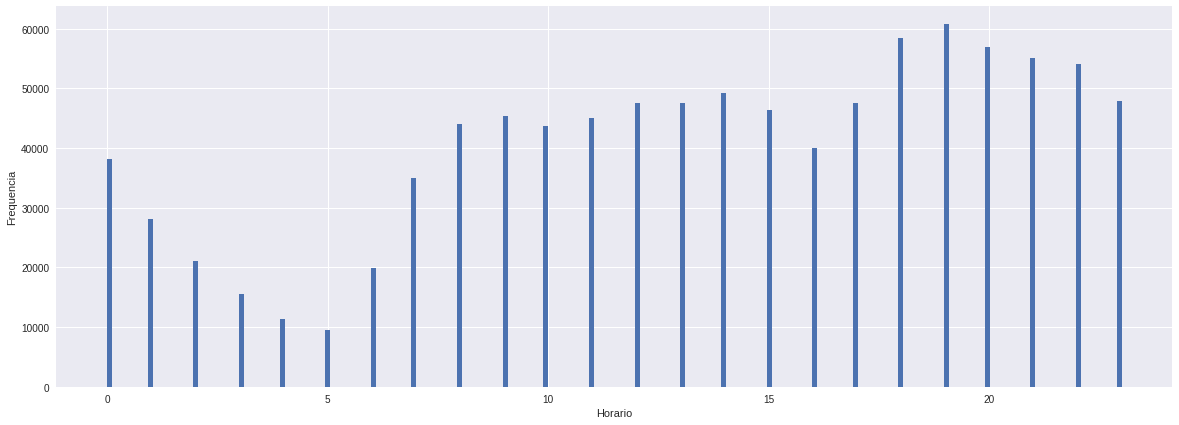

In [294]:
# Primeiro vamos estudar como está distribuida o horário os quais os taxis são pegos

plt.figure(figsize=(20,7))

chunk['Horario'].hist(bins=200)
plt.xlabel('Horario')
plt.ylabel('Frequencia')

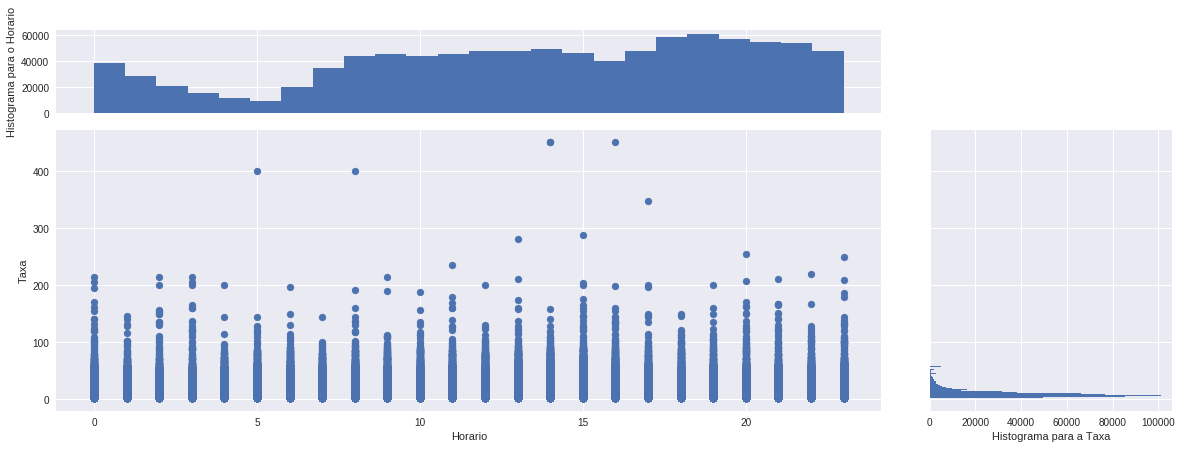

In [295]:


# plt.figure(figsize=(20,7))

# plt.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
# plt.xlabel('Horario')
# plt.ylabel('Taxa paga')


# Vamos ver como fica a distribuição do preço pago pelo horário


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()




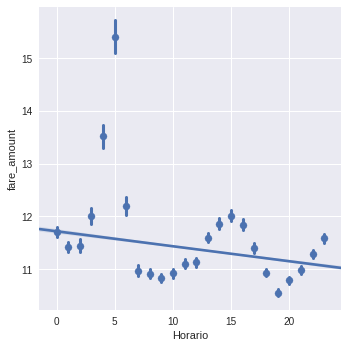

In [296]:
sbs.lmplot(x='Horario', y='fare_amount',data=chunk, x_estimator=np.mean)

(0, 20)

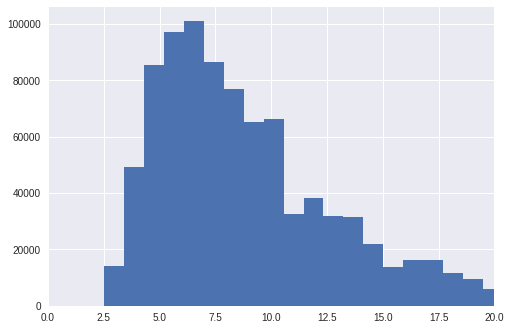

In [297]:
plt.hist(chunk['fare_amount'],bins=500)
plt.xlim((0,20))

In [298]:
chunk['fare_amount'].describe()

count    968332.000000
mean         11.332848
std           9.640004
min           2.500000
25%           6.000000
50%           8.500000
75%          12.500000
max         450.000000
Name: fare_amount, dtype: float64

Dos gráficos podemos inferir que ocorrem mais viagens entre as 18h e 21h, que é o horário em que geralmetne as pessoas voltam de seus trabalhos para casa. Todavia, o horário não parece impactar tanto no preço.

Também, vemos que a maioria das viagens custam, em média, 11.35 com um desvio padrão de 9.82


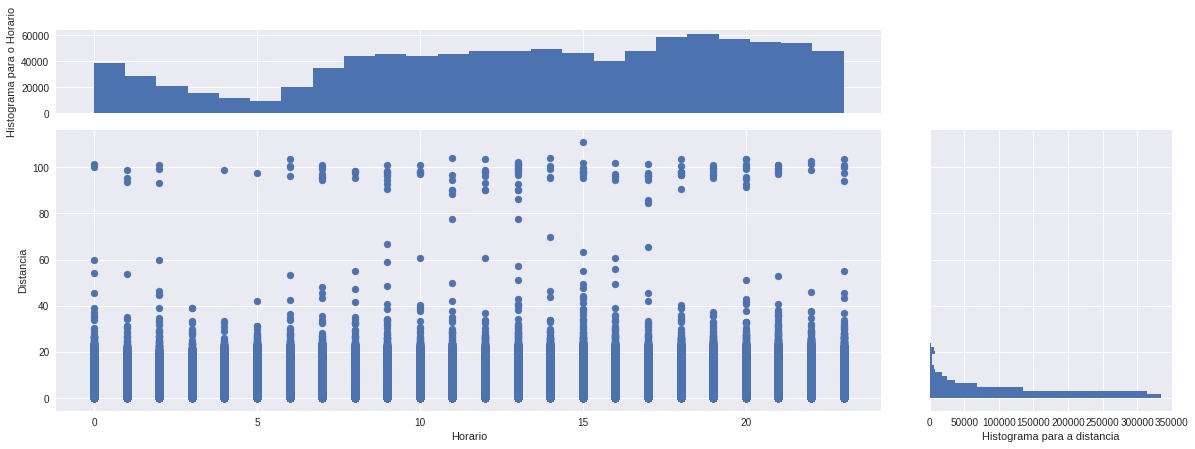

In [299]:
# Mas será que o horário impacta na distancia viajada?


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['distancia'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['distancia'],orientation="horizontal",bins=70)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Distancia')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a distancia')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()


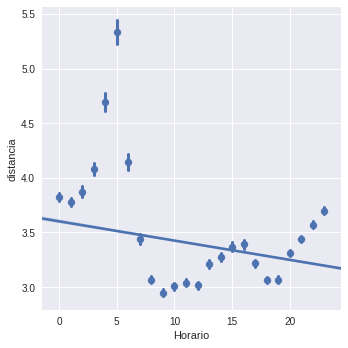

In [300]:
sbs.lmplot(x='Horario', y='distancia',data=chunk, x_estimator=np.mean)


Vemos assim a relação entre horário e distância viajada

#**Hipótese 3**


---
O dia da semana o qual o taxi foi pego impacta no valor?


Text(0, 0.5, 'Frequencia')

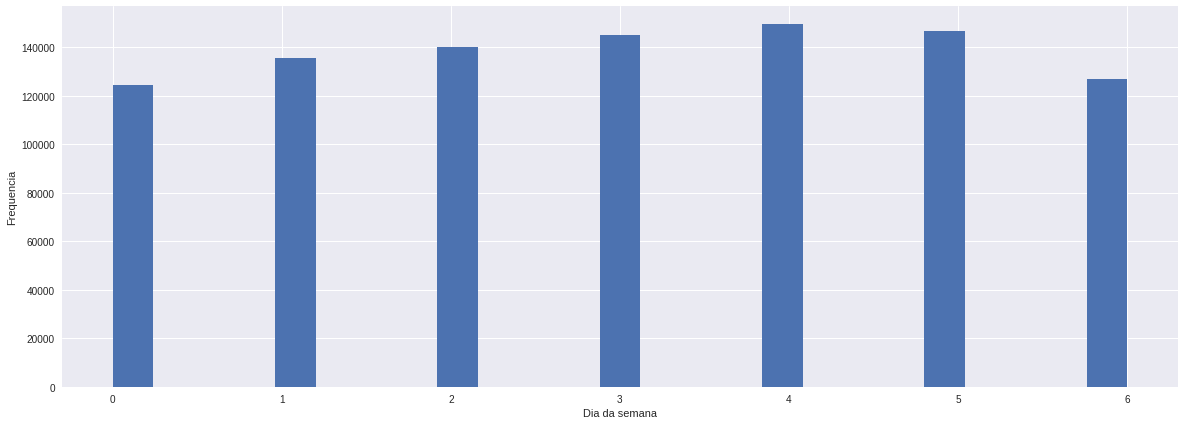

In [301]:
# Primeiro vamos estudar como está distribuida a demanda por taxis ao longo dos dias da semana

plt.figure(figsize=(20,7))

chunk['Dia da semana'].hist(bins=25)
plt.xlabel('Dia da semana')
plt.ylabel('Frequencia')

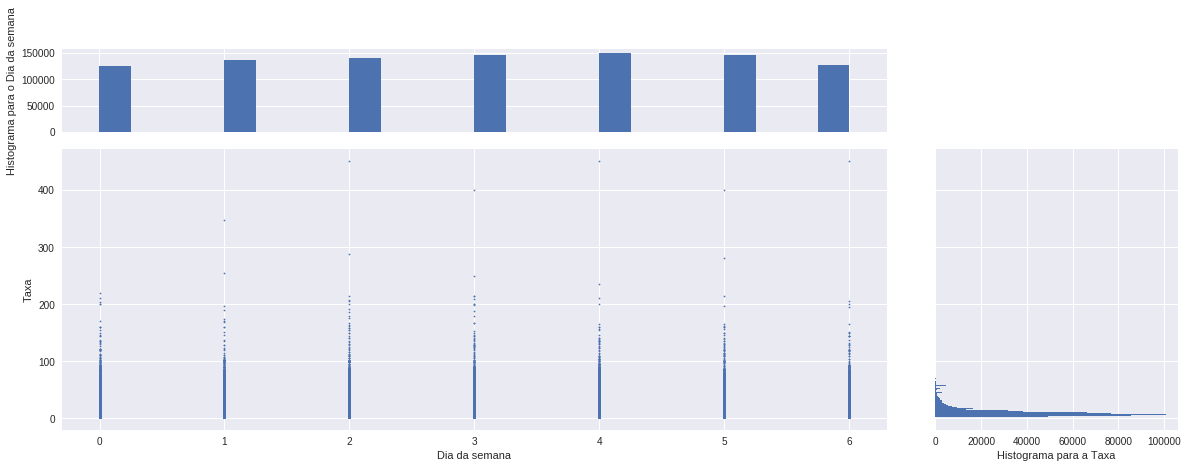

In [302]:
# Qual é a relação entre o dia da semana e ataxa paga?

fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])


ax_joint.scatter(x=chunk['Dia da semana'], y=chunk['fare_amount'],s=1.7)

ax_marg_x.hist(chunk['Dia da semana'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Dia da semana')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Dia da semana')
plt.show()


Podemos ver que o dia da semana que os taxis são mais requisitados é na quinta, 

(0, 25)

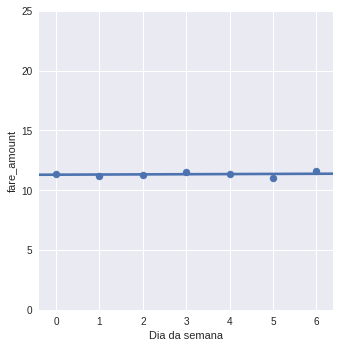

In [303]:
# fazendo uma análise usando o boxplot temos

sbs.lmplot(x='Dia da semana', y='fare_amount',data=chunk, x_estimator=np.mean)
plt.ylim((0,25))

Observando essa regressão, vemos que a taxa média é aproximadamente constante. Logo, a taxa não varia com o dia da semana 

#**Hipótese 4**


---

O local onde o taxi foi pego tem relação com a taxa?

In [0]:
#Vamos ver como fica um plot de densidade dos pickup e dropoff

def distance(lat1, long1, lat2, long2):
#     p = 0.017453292519943295 # Pi/180
#     a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
#     return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...
  R = 6371 # raio da terra em km

  phi_1 = np.radians(lat1)
  phi_2 = np.radians(lat2)

  delta_phi    = np.radians(lat2 - lat1)
  delta_lambda = np.radians(long2 - long1)

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km
  return d


  
# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays


bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(chunk.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(chunk.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(chunk.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(chunk.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

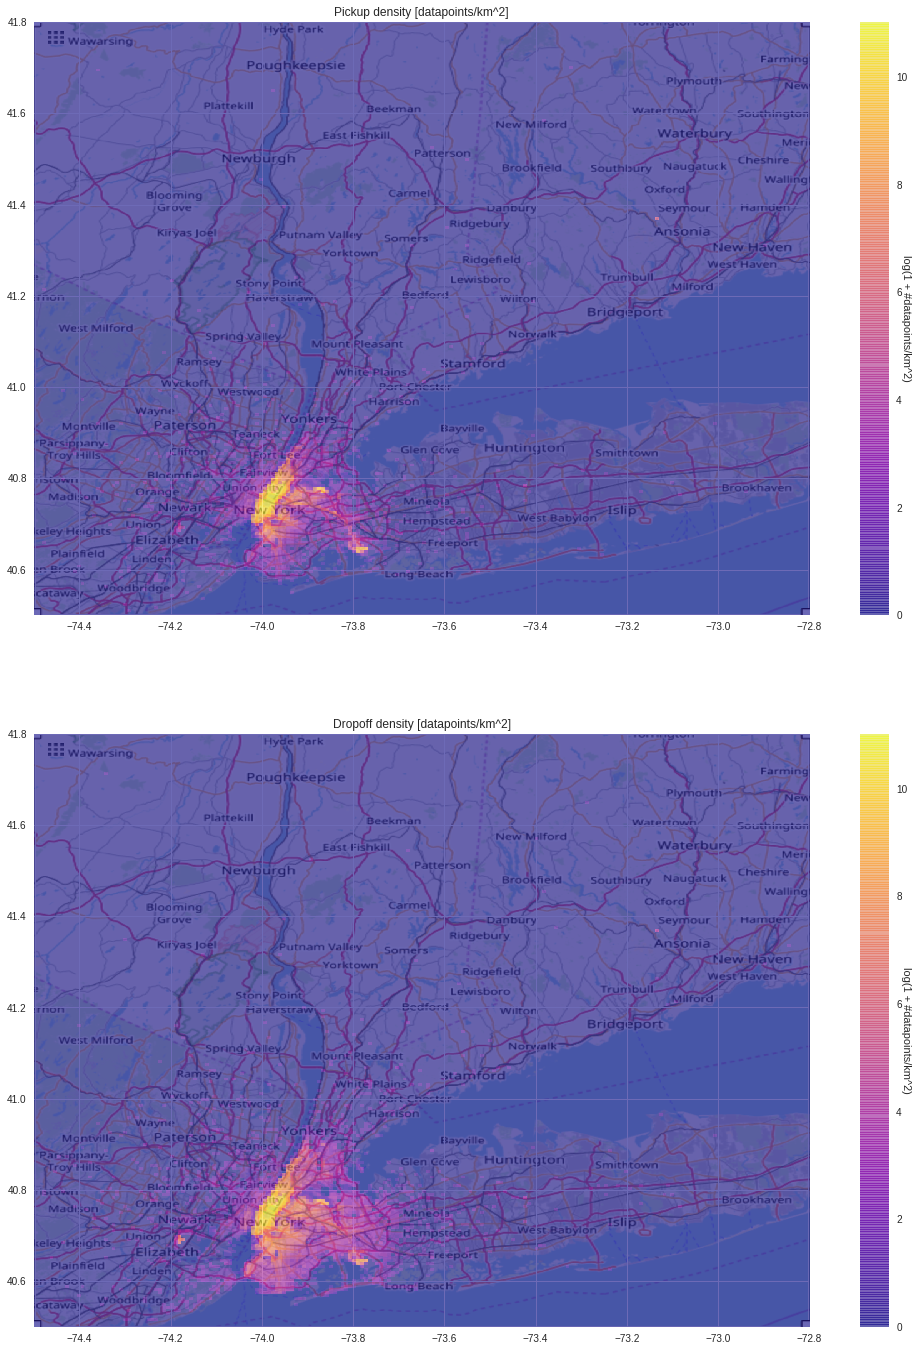

In [305]:
# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_mapa, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints/km^2]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints/km^2)', rotation=270)

axs[1].imshow(nyc_mapa, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints/km^2]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints/km^2)', rotation=270)


Observamos que temos 3 pontos mais afastados do centro de NYC (Manhattan). 

Ao procurar-los no google maps, vi que eles são 3 aeroportos: 

- Aeroporto John F. Kennedy (JKF)
  - Latitude: 40.6413
  - Longitude: -73.7781

- Aeroporto LaGuardia (LGA)
  - Latitude: 40.7769
  - Longitude:-73.8739

- Aeroporto Newark (EWR) 
  - Latitude: 40.7026
  - Longitude: -74.1878
  
  
Então, vamos analisar a taxa paga em função desses três focos de fluxo de taxi -- que estão mais evidentes no mapa

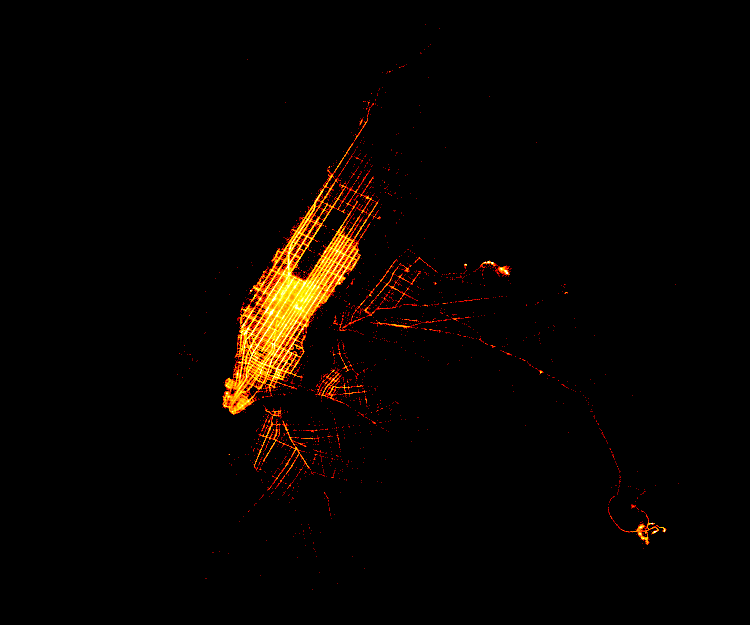

In [306]:
# função para plotar as coordenadas no mapa de NYC

def plot_data_points(longitude,latitude,data_frame,focus_point) :
    #plot dimensions
    x_range, y_range = ((-74.14,-73.73), (40.6,40.9))
    plot_width  = int(750)
    plot_height = int(plot_width//1.2)
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    #plot data points
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height,
                    x_range=x_range, y_range=y_range)
    agg = cvs.points(data_frame,longitude,latitude,
                      ds.count(focus_point))
    img = tf.shade(agg, cmap= Hot, how='eq_hist')
    image_xpt  =  tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,"NYCT_hot")


# taxa paga em função do ponto onde as pessoas pegam taxi
plot_data_points('pickup_longitude', 'pickup_latitude',chunk,'fare_amount')

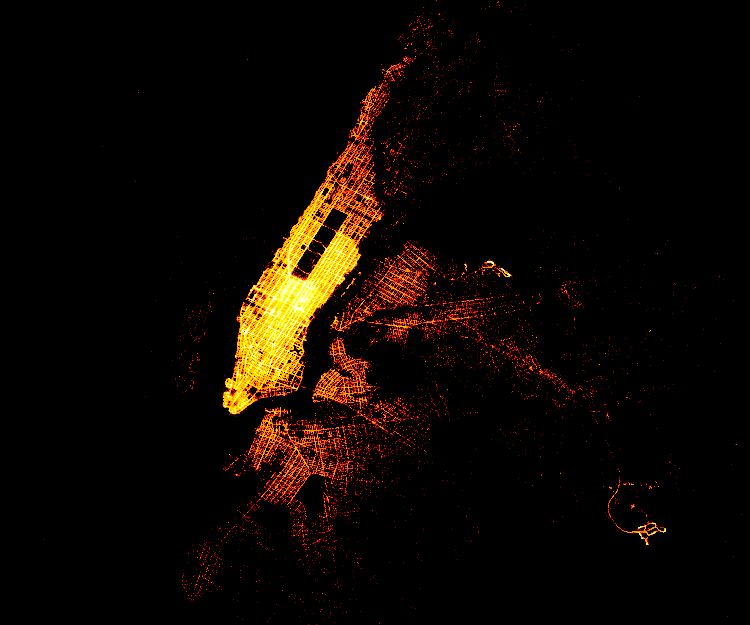

In [307]:
#Taxa paga em função do ponto em que são deixada as pessoas

plot_data_points('dropoff_longitude', 'dropoff_latitude',chunk,"fare_amount")

Observo que as maiores taxas são pagas por pessoas que:

- Vem ou vão para o JKF

- Vem ou vão para o LGA

- Estão no centro de Manhattan

Também, há esse fenômeno interessante de uma grande concentração de "pegar taxi" em Manhattan, e uma maior dispersão no "ponto de deixada" do taxi.
Possivelmente, as pessoas pegam taxi para se dirigir para suas casas. Explicando, assim o motivo da maior dispersão para os destinos em função da taxa paga.

In [0]:
# Vamos analisar brevemente como é o custo médio da tarifa para as pessoas que vão para os aeroportos

"""
- Aeroporto John F. Kennedy (JKF)
  - Latitude: 40.6413
  - Longitude: -73.7781

- Aeroporto LaGuardia (LGA)
  - Latitude: 40.7769
  - Longitude:-73.8739

- Aeroporto Newark (EWR) 
  - Latitude: 40.7026
  - Longitude: -74.1878
"""

# Pares Lat/long 

jkf = (40.6413, -73.7781)
lga = (40.7769, -73.8739)
ewr = (40.7026, -74.1878)


chunk['distancia JKF PICKUP']  = chunk.apply(lambda x: distance(jkf[0],jkf[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
chunk['distancia JKF DROPOFF'] = chunk.apply(lambda x: distance(jkf[0],jkf[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

chunk['distancia LGA PICKUP'] = chunk.apply(lambda x: distance(lga[0],lga[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
chunk['distancia LGA DROPOFF'] = chunk.apply(lambda x: distance(lga[0],lga[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

chunk['distancia EWR PICKUP'] = chunk.apply(lambda x: distance(ewr[0],ewr[1],x['pickup_latitude'],x['pickup_longitude']), axis=1)
chunk['distancia EWR DROPOFF'] = chunk.apply(lambda x: distance(ewr[0],ewr[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)



In [0]:
# Vamos ver como é a distribuição das viagens que partem dos aeroportos

# Primeiro vamos filtrar pelos destinos

indo_jkf   = chunk[chunk['distancia JKF PICKUP']  <2]
volta_jkf  = chunk[chunk['distancia JKF DROPOFF'] <2]

indo_lga   = chunk[chunk['distancia LGA PICKUP']  <2]
volta_lga  = chunk[chunk['distancia LGA DROPOFF'] <2]

indo_ewr   = chunk[chunk['distancia EWR PICKUP']  <2]
volta_ewr  = chunk[chunk['distancia EWR DROPOFF'] <2]

In [0]:
# Viagens que não vão para aeroporto algum

# remover os do jkf
not_aeroporto = chunk.drop(
                           indo_jkf.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_jkf.index, axis=0
                          )

# remover os do lga
not_aeroporto = chunk.drop(
                           indo_lga.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_lga.index, axis=0
                          )

# remover os do ewr
not_aeroporto = chunk.drop(
                           indo_ewr.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_ewr.index, axis=0
                          )


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



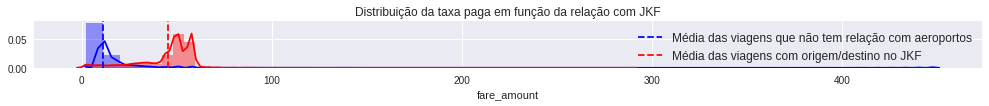

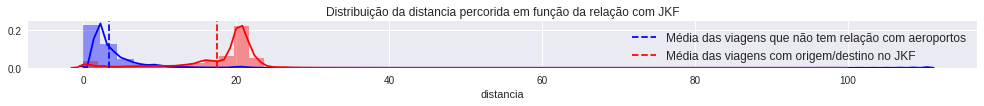

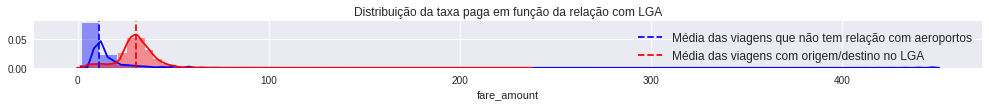

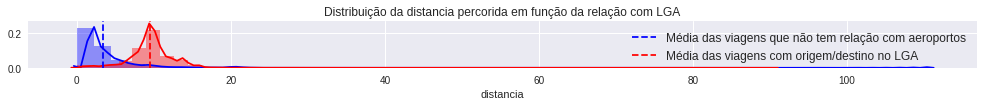

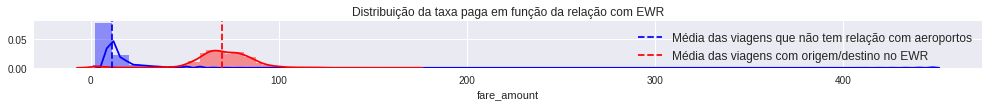

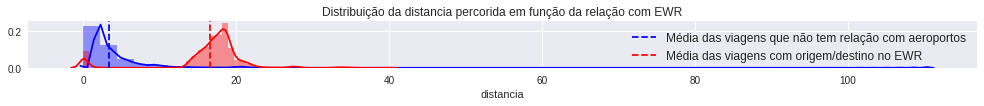

In [311]:
# Comparar a distribuição dos preços pagos e o aeroporto

# JKF

jkf_geral = pd.concat([indo_jkf, volta_jkf])


plt.figure(figsize= (17,6))
plt.subplot(611)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(jkf_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(jkf_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no JKF'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com JKF")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(612)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(jkf_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(jkf_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no JKF'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com JKF")
plt.show()
# FIM DA ANALISE DO JKF

# LGA

lga_geral = pd.concat([indo_lga, volta_lga])


plt.figure(figsize= (17,6))
plt.subplot(613)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(lga_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(lga_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no LGA'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com LGA")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(614)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(lga_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(lga_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no LGA'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com LGA")
plt.show()

# Fim da análise do LGA

# EWR

ewr_geral = pd.concat([indo_ewr, volta_ewr])


plt.figure(figsize= (17,6))
plt.subplot(615)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(ewr_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(ewr_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no EWR'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com EWR")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(616)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(ewr_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(ewr_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no EWR'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com EWR")
plt.show()


###Dos gráficos acima, observa-se que:

1 -  Em geral, corridas que estão relacionadas com aeroportos são mais caras
    
    - isso era esperado porque, como citado anteriormente, para corridas relacionadas a aeroportos existem taxas extras
    
    - Também, devido a maior distância que os aeroportos possuem do centro de NYC (Manhattan) impactará numa taxa maior
    
2 -  Corridas pegas no aeroporto LGA tendem a ser mais baratas

    - Uma possível justificativa é o fato do aeroporto está mais próximo a áreas residenciais/hotel -- ao contrário dos outros

3 - Corridas pegas no aeroporto EWR tendem a percorrer a ser mais caras
    
    - Novamente, devido a distância que o aeroporto tem das áreas residenciais e de hotel.

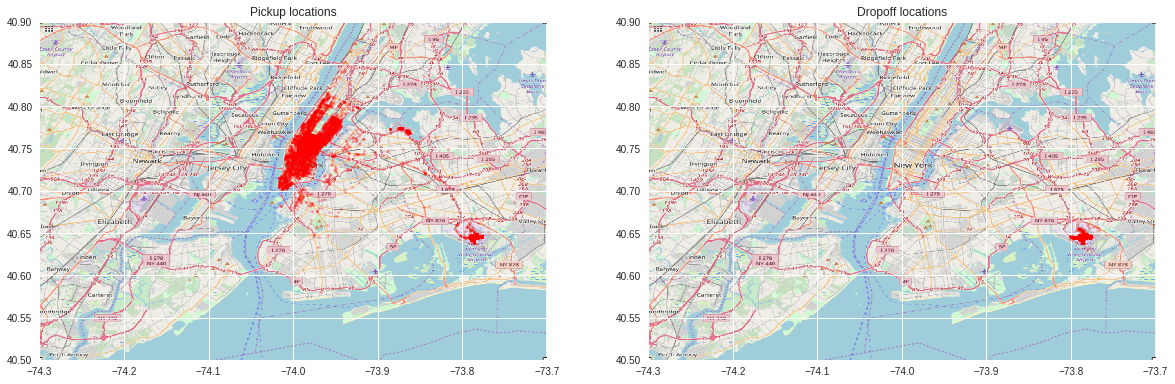

In [312]:
# Destinos relacioados ao JKF
plot_on_map(volta_jkf, BB_zoom, nyc_mapa_zoom, s=5, alpha=0.3)



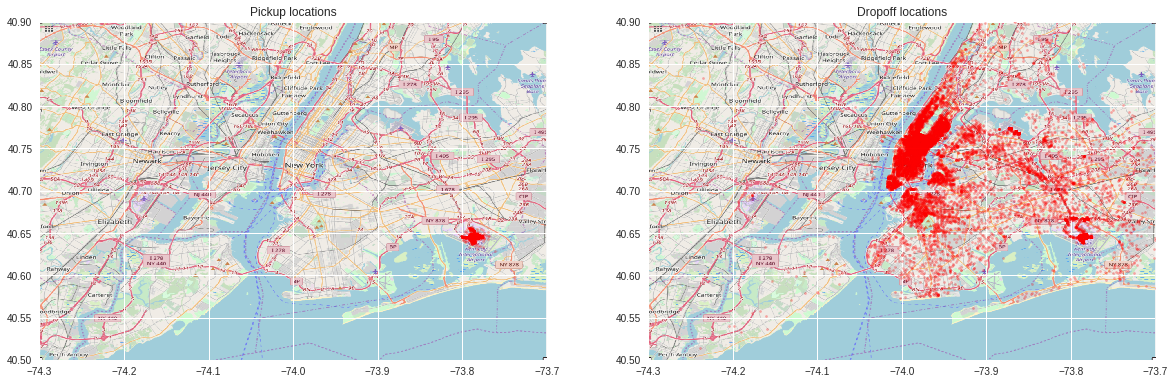

In [313]:
# Origens relacioados ao JKF
plot_on_map(indo_jkf, BB_zoom, nyc_mapa_zoom, s=5, alpha=0.3)


Observando estes gráficos, confirmo a minha hipótese de que 

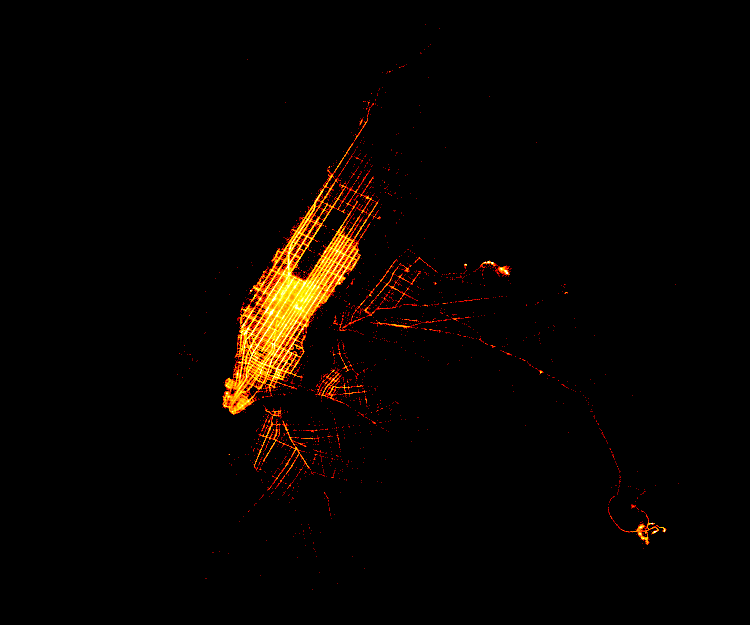

In [314]:
# Outra análise interessante a se fazer:

plot_data_points('pickup_longitude', 'pickup_latitude',chunk,'distancia')

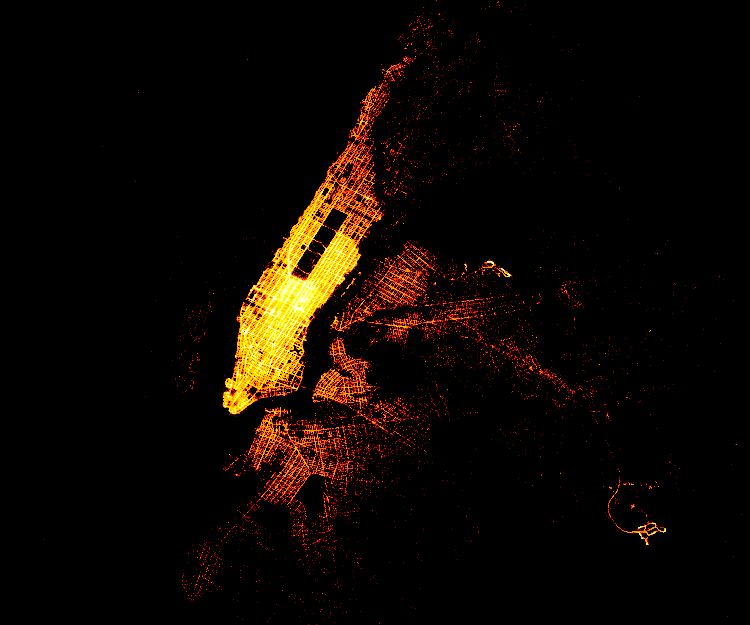

In [315]:
plot_data_points('dropoff_longitude', 'dropoff_latitude',chunk,"distancia")

Obtemos um comportamento parecido quando plotamos o mesmo gráfico, contudo com a intensidade do brilho variando de acordo com a distancia percorrida. Evidenciando, assim, que a distância está correlacionada com a taxa paga

# **Hipótese 5**

---

A distância influencia na taxa?

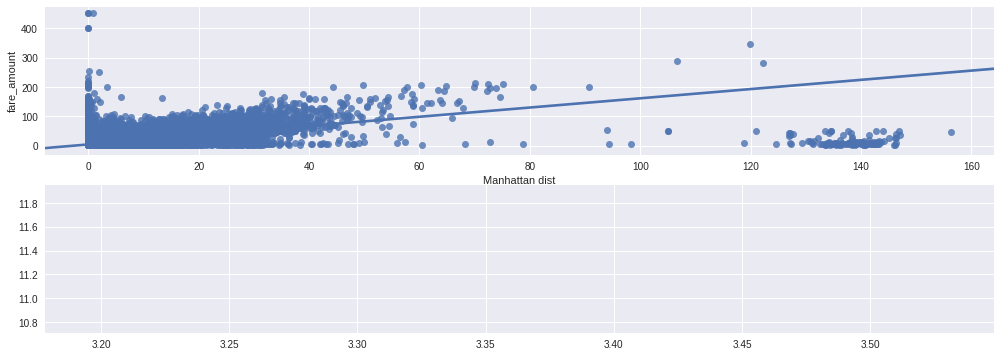

In [316]:
# Primeiro, farei uma regressão linear para ver como a taxa paga se comporta em função das distâncias

plt.figure(figsize= (17,6))
plt.subplot(211)

sbs.regplot(x='Manhattan dist',y= 'fare_amount', data=chunk)

plt.subplot(212)
sbs.regplot(x='distancia',y= 'fare_amount', data=chunk, x_estimator=np.mean)

Dos gráficos, observamos o que já era suspeito: de que tais métricas impactam fortemente no valor da taxa. 

Agora, vamos desprezar os elementos cuja taxa paga foi zero e refazer esta análise


# Machine Learning

---

Usarei, por simplicidade, um modelo de regressão linear. Entretanto, sei que este modelo não será tão preciso -- todavia, por falta de tempo, irei utilizar-lo.

In [0]:
# Adicionando features que usei na EDA para o teste

teste = remove_datapoints_from_water(test, BB)

teste['key']             = pd.to_datetime(teste['key'])

teste['pickup_datetime'] = pd.to_datetime(teste['pickup_datetime'])

teste['Ano'] = teste['pickup_datetime'].dt.year
teste['Mes'] = teste['pickup_datetime'].dt.month
teste['Dia'] = teste['pickup_datetime'].dt.day
teste['Dia da semana'] = teste['pickup_datetime'].dt.dayofweek
teste['Horario'] = chunk['pickup_datetime'].dt.hour

teste['Noite'] = teste.apply(lambda x: noite(x), axis=1)
teste['Madrugada'] = teste.apply(lambda x: madrugada(x), axis=1)

def haversine_2 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(teste[lat1])
  phi_2 = np.radians(teste[lat2])

  delta_phi    = np.radians(teste[lat2] - teste[lat1])
  delta_lambda = np.radians(teste[long2] - teste[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  teste['distancia'] = d 
  return d
                                 

haversine_2('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')



teste['distancia JKF PICKUP']  = teste.apply(lambda x: distance(jkf[0],jkf[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
teste['distancia JKF DROPOFF'] = teste.apply(lambda x: distance(jkf[0],jkf[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['distancia LGA PICKUP']  = teste.apply(lambda x: distance(lga[0],lga[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
teste['distancia LGA DROPOFF'] = teste.apply(lambda x: distance(lga[0],lga[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['distancia EWR PICKUP']  = teste.apply(lambda x: distance(ewr[0],ewr[1],x['pickup_latitude'],x['pickup_longitude']), axis=1)
teste['distancia EWR DROPOFF'] = teste.apply(lambda x: distance(ewr[0],ewr[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['Manhattan dist']=teste[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].apply(lambda x: manhattan(x[0], x[1], x[2], x[3]), axis=1)


In [0]:
corr = chunk.corr()

sbs.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

In [0]:
# eliminando features zoadas do teste
test_block  = teste.drop(['distancia EWR PICKUP','distancia EWR DROPOFF','distancia LGA DROPOFF','distancia LGA PICKUP','distancia JKF DROPOFF','distancia JKF PICKUP','passenger_count','Ano','Dia','Dia da semana','Horario','Noite','Madrugada','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','Mes','key','pickup_datetime'], axis=1)

# eliminando features que não servirão para o treino
train_block = chunk.drop(['distancia EWR PICKUP','distancia EWR DROPOFF','distancia LGA DROPOFF','distancia LGA PICKUP','distancia JKF DROPOFF','distancia JKF PICKUP','passenger_count','Ano','Dia','Dia da semana','Horario','Noite','Madrugada','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','Mes','key','pickup_datetime'], axis=1)


In [0]:
test_block = test_block.dropna()
train_block = train_block.dropna()
train_obj   = train_block['fare_amount']

train_block = train_block.drop(['fare_amount'], axis=1)

In [0]:
test_block.head()

In [0]:
train_block.head()

In [0]:
# Regressão linear

from sklearn.linear_model import LinearRegression

regressao = LinearRegression()
regressao.fit(train_block, train_obj)

regressao_pred = regressao.predict(test_block)


In [0]:
reg_df = pd.DataFrame({'fare_amount':regressao_pred} )

In [0]:
reg_df.head(50)
